In [15]:
import os

In [2]:
test_image_dir="../data/test_images_phase1/"
test_csv="../data/test_phase1_v2.csv"

In [4]:
import pandas as pd

submission_df = pd.read_csv(test_csv)
submission_df.head()

,img_fName,img_w,img_h
0,ce8f0ede-4366-45b9-bdd4-959e17c7618c.jpeg,1599,965
1,f207780c-0d0a-4d41-bd95-92ca53ff81a3.jpeg,822,861
2,99c6b7f9-dbea-4635-a18d-cde16b125515.jpeg,720,1280
3,662b4405-3600-41b9-9812-451b6d9df322.jpeg,3024,4032
4,1de14b6b-6781-4a24-ae5e-f760e865c758.jpeg,1242,2208


In [7]:
from hydra import compose, initialize, core as hydra_core

hydra_core.global_hydra.GlobalHydra.instance().clear()
initialize(config_path="../exps", version_base=None)
cfg = compose(config_name="submission")


In [11]:
import sys

sys.path.append("../")

In [35]:
import torch
from mosquito.models import models

model = models[cfg.model_name](cfg, num_classes=6)
model.load_state_dict(torch.load(cfg.model_path, map_location=torch.device("cpu")))

<All keys matched successfully>

In [17]:
test_images = [os.path.join(test_image_dir, x) for x in submission_df["img_fName"].values]

[{'boxes': tensor([], size=(0, 4)), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([])}]


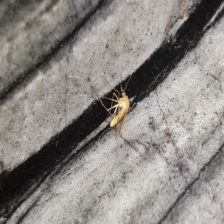

In [56]:
import PIL.Image
from torchvision import transforms

bboxes_preds = []
labels_preds = []

model.eval()

image = PIL.Image.open(test_images[0]).convert("RGB")
image_t = transforms.Compose([
    transforms.Resize((cfg.input_size, cfg.input_size)),
    transforms.ToTensor()
])(image).unsqueeze(0)

with torch.no_grad():
    outputs = model.model(image_t)
    print(outputs)
    

PIL.Image.fromarray((image_t * 255).squeeze(0).permute(1, 2, 0).numpy().astype("uint8"))